# Tutorial 1: How to create a simple deep neural network with PyTorch

In this first Tutorial we will cover the basic steps and elements to create a deep neural network in PyTorch.

## Preperations
Before we get started, make sure that PyTorch, Torchvision, and Torchaudio are properly installed. If not, follow the previous tutorial.

### Checking the available devices

To optimize the processing graph of the neural network, PyTorch uses the "device" variable to define if the calculation of the neural network should be performed on a CUDA-device (a GPU) or the CPU. 
Is it recommend to use the GPU, as the training procedure will be calculated much faster than on the CPU.

Therefore, after importing the main package torch, we check with `torch.cuda.is_available()` if a CUDA capable GPU is available. 
If not, we will run the network on the CPU, otherwise on the GPU.

In [1]:
import torch

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Device is ',device)

Device is  cuda


### Import training and test set
We use the Torchvision package, as it contains many common datasets, to load the training and test set for the MNIST dataset.
It contains images from handwritten digits with a resolution of $28 \times 28$ pixels.

With help of the `torchvision.transforms` sub package, we create a transform-object which we can use to normalize the pixel-value. Why data needs to be normailzed or be preprocessed otherwise, will be covered in a future tutorial.

Additionally, we will create two `DataLoader`objects, one for the training and one for the test set, which we will use to load the datasets batchwise. Splitting the whole dataset in smaller batches often results in faster training and a stable convergence.

`trainset.classes` gives us the labels of the classes, but we can define them as we like. It is technically irrelevant for the training. The output of the network will be matched with this list for human readabilty.

In [2]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))])
batch_size=4
trainset = torchvision.datasets.MNIST(root='../Dataset/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../Dataset/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# list of class labels
classes = trainset.classes
print(classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


### Plot some sample images

We use the Matplotlib library to show the first four samples from the MNIST training set.

Classes are: 
1 - one 8 - eight 0 - zero 1 - one


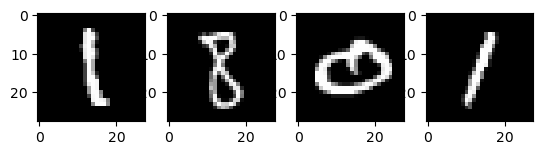

In [3]:
import matplotlib.pyplot as plt

def imshow(imges):
    plt.figure()
    for i in range(4):
        img = imges[i,0]
        img = img / 2 + 0.5 #unnormalize
        npimg = img.numpy()
        plt.subplot(1,4,i+1)
        plt.imshow(npimg, cmap='gray')
    plt.show

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(images)

print('Classes are: ')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Create the deep neural network

### The network class

To define a neural network in PyTorch, we create a class object which inherits from the `torch.nn.Module`class.
Inside of this class, we 1) create the layer objects which will build the structure of our network and then 2) define the feedforward processing path through the network. 

#### Define the network structure

This is done in the `__init__`function.
As many common layers are predefined in PyTorch already, we use the `torch.nn` sub package to access them. We want to create a network with one input layer, a hidden layer and an output layer. Each fully-connected layer has the number of inputs and the number of outputs as parameters.

The first layer gets the MNIST-images as input which is why the number equals $28x28$. The output parameter can be freely chosen and expiremented with. It corresponds to the number of neurons in its layer and is a hyperparameter to be tuned.

`self.fc1 = nn.Linear(16*4*4,120)`

Then we add a second fully-connected layer which needs the number of outputs of the previous layer as its number of inputs. The output, again, is to be experimented with.

`self.fc2 = nn.Linear(120,84)`

We end with the classification head (also a fully-connected layer) with 10 output neurons which correspond to our 10 MNIST-labels (0-9):

`self.fc3 = nn.Linear(84,10)`

Please note, that here we only define, which layers we want to use in our network. The order of defining them is not important at the moment.

#### Define the feedforward path

Now that the structure is defined, we 2) define the feedforward processing path through the network in the `forward(self, x)` function. 
Or to say it differently, we connect the single layers with each other by defining which layers output becomes which layers input.

As `x` represents the input to our network, it is processed by the first fully connected layer. Additionally, we apply the ReLU function as activation function on the output of each layer except the output layer.

`x = F.relu(self.fc1(x))`

`x = F.relu(self.fc2(x))`

Finally, we return the output of the classification head as the final output of our network:

`x = self.fc3(x)`

`return x`

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## define the network structure with the layers
        self.fc1   = nn.Linear(28*28, 120) # in_channels, out_channels
        self.fc2   = nn.Linear(120,84) # in_channels, out_channels
        self.fc3   = nn.Linear(84,10) # in_channels, out_channels

        
    def forward(self, x):
        ## define the functionality of each layer/between the layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Creating the network
Now we can simply create a new network object and assign it to the device identified above.

In [5]:
net = Net().to(device)

### Set up loss and optimizer
We use the `CrossEntropyLoss`as loss-function on the error between the network output and the correct labels and using the simple
Stochastic-Gradient-Desced (`SGD`) optimizer.
Please note, that the optimizer needs the parameters of our network `net.parameters()` as input to define which need to be tuned.

Further available loss functions and optimizers can be found on the [official PyTorch website](https://pytorch.org/docs/stable/nn.html)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training the network
To train the network, we need a double for-loop.
The inner loop uses the trainloader object defined above to iterate over the batches of the training set. 

For each batch, we get the input data (the images) and the corresponding labels and assign them to the identified device due to performance reasons.
    
As we calculate the gradients of the weights for each batch independently, we set the gradients to zero:
    
`optimizer.zero_grad()`
    
Then we calculate the output of the network, depending on the inputs, calculating the loss and then propagating the error along the backward path automatically.
    
`outputs = net(inputs)`
    
`loss = criterion(outputs, labels)`
    
`loss.backward()`
    
We apply the gradients via the optimzer:
    
`optimizer.step()`
    
And printing out the loss from the current batch at the end.

All this is repeated for 2 epochs (the outer loop).

To pass the 28x28 image to the first layer of the neural network, we need to flatten the image to convert it from a 2D to a 1D-vector. 

In [7]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the input data and labels
        inputs, labels = data
        inputs = inputs.flatten(start_dim=1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimze
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch +1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.816
[1,  4000] loss: 0.381
[1,  6000] loss: 0.333
[1,  8000] loss: 0.278
[1, 10000] loss: 0.244
[1, 12000] loss: 0.217
[1, 14000] loss: 0.209
[2,  2000] loss: 0.172
[2,  4000] loss: 0.157
[2,  6000] loss: 0.165
[2,  8000] loss: 0.152
[2, 10000] loss: 0.159
[2, 12000] loss: 0.151
[2, 14000] loss: 0.137
Finished Training


After training, we save the parameters of the trained network.

In [8]:
path = './mnist_mlp_net.pth'
torch.save(net.state_dict(), path)

## Test the network performance
We use the testloader object to see, how well the network will recognize the numbers in the test set.

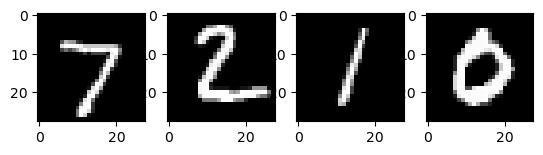

In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(images)

We create a new network object and load the parameters from the trained network

In [10]:
net = Net()
net.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

By passing the flattened first images as parameter to the `net()`, we compute the classification for each image.

In [11]:
output = net(images.flatten(start_dim=1))

_, predicted = torch.max(output, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  7 - seven 2 - two 1 - one 0 - zero


As this looks very promising, we write a loop to get the data from the testload batchwise and pass them through the network. To compute the accuracy, we check how many images were correctly identified and devide it by the total number of images.

To avoid further training and to reduce the computational costs, we deactivate the calculation of gradients with `torch.no_grad()`

In [12]:
correct = 0
total   = 0

# use no_grad as we do not want further training
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.flatten(start_dim=1)
        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print(f'Accuracy of the network on the test set: {100*correct // total}%')

Accuracy of the network on the test set: 96%


## Exercise 1: Implement a multi-layer neural network for the FashionMNIST dataset

Use the previous code as guidance for this task. The FashionMNIST is a little more complex dataset than the classic MNIST but only uses 10 classes of simple images of clothing items. Load them as before with `trainset = torchvision.datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)`; test set accordingly.

Experiment with layer sizes, number of epochs, number of layers and batch size.

In [13]:
# immport torch and set device

In [14]:
# load and plot data

In [15]:
# define neural network layer and feedforward pass

In [16]:
# create network and define loss function and optimizer

In [17]:
# train the network and save the result

In [18]:
# load the saved network

In [19]:
# evaluate accuracy

## Conclusion

So in this tutorial we have covered:

1. How to use DataLoader to initialize the training and test set to present them batchwise to the network.
2. How to define the structure of the network and the feedforward path.
3. How to define the loss function and optimizer.
4. How to write the training loop to apply the gradients on the network parameters.
5. How to measure the network performance on the test set.